# Automatize the PoC

This notebook follows the first one "20230725 - PoC" in order to automatize the process from a given list of tickers to the results. In this notebooks, we will add the possibility to change the data to the return ratio. 

In [180]:
from typing import List

import pandas as pd
import yfinance as yf
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import functools as ft
import networkx as nx
import numpy as np

import torch
from torch_geometric.data import Data, Batch

## Prepare Data Function

In [181]:
def prepare_data(
    symbols: List[str],
    how_merge_symbol: str = "inner",
    convert_roc: bool = True,
) -> pd.DataFrame:
    list_dfs_symbols = []
    for symbol in tqdm(symbols):
        ticker = yf.Ticker(symbol)
        df_symbol = ticker.history(period="max").reset_index()[["Date", "Close"]]
        df_symbol["Date"] = pd.to_datetime(df_symbol['Date'].dt.strftime('%Y-%m-%d'))
        df_symbol.columns = ["Date", symbol.lower() + "_close"]
        list_dfs_symbols.append(df_symbol)
        
    df_symbols = ft.reduce(lambda left, right: pd.merge(left, right, on='Date', how = how_merge_symbol), list_dfs_symbols)
    df_symbols = df_symbols.sort_values("Date").set_index("Date")
    
    # for american stock that close, lets forward fill
    if how_merge_symbol == "outer":
        # detect american stocks
        for s in df_symbols.columns:
            if df_symbols[s][-30:-1].isna().sum()/30 > 0.20:
                df_symbols[s].ffill(inplace=True)
     
                
    if convert_roc:
        df_roc = df_symbols/df_symbols.shift(1) - 1
            
    return df_symbols, df_roc.dropna()

In [182]:
SYMBOLS = ['MSFT', 'IWO', 'VFINX', '^GSPC', 'BTC-USD']
df_price, df_roc = prepare_data(
    symbols = SYMBOLS,
    how_merge_symbol="outer")

100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


## Build Dataset Function

In [183]:
def build_dataset(
    data: pd.DataFrame,
    past_k: int,
    test_size: float
):
    
    # Create a mapping of node names (stocks) to integers
    node_mapping = {node: i for i, node in enumerate(data.columns)}

    training_list = []
    testing_list = []
    
    N = len(data)    

    for t in tqdm(range(past_k, N)):
        
        # Step 1: Create correlation matrix and graph for this time step
        correlation_matrix = data.iloc[:t].corr()
        graph = nx.from_pandas_adjacency(correlation_matrix)
        graph.remove_edges_from(nx.selfloop_edges(graph))

        # Step 2: Convert edges to integer tuples and store as tensor
        edges = list(graph.edges)
        edges_mapped = [(node_mapping[u], node_mapping[v]) for u, v in edges]
        edge_indices = torch.tensor(edges_mapped, dtype=torch.long).t().contiguous()

        # Step 3: Store edge weights as tensor
        edge_weights = torch.tensor([graph[u][v]['weight'] for u, v in edges], dtype=torch.float)

        # Step 4: Store closing prices as node features (assume last column of df is 'Close')
        node_features = torch.tensor(data.iloc[t-past_k:t, :].T.values, dtype=torch.float)
        
        # Step 5: Store prices at t+1 as labels
        labels = torch.tensor(data.iloc[t, :], dtype=torch.float)
        
        if t < N - test_size:
            training_list.append(
                Data(x=node_features, edge_index=edge_indices, edge_attr=edge_weights, y = labels)
            )
        else:
            testing_list.append(
                Data(x=node_features, edge_index=edge_indices, edge_attr=edge_weights, y = labels)
            )
             
    # Convert data_list into a Batch for feeding into your model
    training_batch = Batch.from_data_list(training_list)
    testing_batch = Batch.from_data_list(testing_list)
    
    return training_batch, testing_batch

In [189]:
trainset, testset = build_dataset(
    data = df_roc,
    past_k = 20,
    test_size = 180
)

100%|██████████| 3211/3211 [00:07<00:00, 437.19it/s]


## Model

In [190]:
import torch.nn.functional as F
from torch_geometric.nn import GraphConv
from torch.optim import Adam

class GNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(num_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)  # Changed num_classes to hidden_channels
        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels)  # MLP hidden layer
        self.fc2 = torch.nn.Linear(hidden_channels, num_classes)  # MLP output layer

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)  # Apply nonlinearity
        x = self.fc1(x)
        x = F.relu(x)  # Apply nonlinearity
        x = self.fc2(x)
        return x


In [191]:
# Assuming node features are 3 and we want to predict next price (1 value)
model = GNN(num_features=20, hidden_channels=8, num_classes=1)

# Define a suitable optimizer
optimizer = Adam(model.parameters(), lr=0.01)

# Define loss function - mean squared error loss
loss_func = torch.nn.MSELoss()

## Training

In [192]:
EPOCH = 5

In [193]:
# Training loop
for epoch in range(EPOCH):
    loss_list = []
    print("EPOCH > ", epoch)
    for data in tqdm(trainset.to_data_list()): # Iterate over each graph in the batch
        model.train()
        optimizer.zero_grad()

        #print("data: ", data)
        # Forward pass
        out = model(data).squeeze()
        
        #print("out: ", out)

        # Calculate loss
        loss = loss_func(out, data.y)
        loss_list.append(loss.item())
        
        
        # Backward pass
        loss.backward()
        optimizer.step()

        model.eval()
    print("Mean Loss: ", np.mean(loss_list))


EPOCH >  0


100%|██████████| 3031/3031 [00:07<00:00, 417.94it/s]


Mean Loss:  0.0005338217577143907
EPOCH >  1


100%|██████████| 3031/3031 [00:06<00:00, 449.13it/s]


Mean Loss:  0.0004648521949487193
EPOCH >  2


100%|██████████| 3031/3031 [00:08<00:00, 378.63it/s]


Mean Loss:  0.0004584062569153129
EPOCH >  3


100%|██████████| 3031/3031 [00:07<00:00, 392.23it/s]


Mean Loss:  0.00045629746760490297
EPOCH >  4


100%|██████████| 3031/3031 [00:05<00:00, 514.57it/s]

Mean Loss:  0.00045616169997893767


## Testing

In [194]:
PRED_COLS_GNN = [col.split("_")[0] + "_pred_gnn" for col in df_roc.columns]
PRICE_COLS = [col for col in df_roc.columns if "close" in col]


In [195]:
preds = []
for i, data in tqdm(enumerate(testset.to_data_list())): # Iterate over each graph in the batch

    out = list(model(data).detach().numpy())
    
    preds.append(out)

df_pred = pd.DataFrame(np.squeeze(np.array(preds)), columns = PRED_COLS_GNN)

180it [00:00, 1889.96it/s]


In [200]:
first_price_date = pd.to_datetime(df_roc.index[0]) - pd.Timedelta(days=1)
first_price = df_price.loc[first_price_date]


In [201]:
df_price_from_roc = pd.concat([pd.DataFrame(first_price).T, 1 + df_roc]).cumprod()

In [202]:
df_pred.index = df_roc.index[-len(df_pred):]

In [203]:
df_result = df_price_from_roc.join(df_pred)
df_result

,msft_close,iwo_close,vfinx_close,^gspc_close,btc-usd_close,msft_pred_gnn,iwo_pred_gnn,vfinx_pred_gnn,^gspc_pred_gnn,btc-usd_pred_gnn
2014-09-17,40.158894,126.549461,159.077789,2001.569946,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-18,40.297001,127.401878,159.884277,2011.359985,424.440002,NaN,NaN,NaN,NaN,NaN
2014-09-19,41.022156,125.706306,159.803268,2010.400024,394.795990,NaN,NaN,NaN,NaN,NaN
2014-09-20,41.022156,125.706306,159.803268,2010.400024,408.903992,NaN,NaN,NaN,NaN,NaN
2014-09-21,41.022156,125.706306,159.803268,2010.400024,398.821014,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-07-19,355.079987,252.520004,421.510010,4565.720215,29913.923828,0.002062,0.002062,0.002062,0.002062,0.002062
2023-07-20,346.869995,250.119995,418.700012,4534.870117,29792.015625,0.002062,0.002062,0.002062,0.002062,0.002062
2023-07-21,343.769989,249.360001,418.829987,4536.339844,29908.744141,0.002062,0.002062,0.002062,0.002062,0.002062
2023-07-22,343.769989,249.360001,418.829987,4536.339844,29771.802734,0.002062,0.002062,0.002062,0.002062,0.002062


In [204]:
for p_col, pred_col in zip(PRICE_COLS, PRED_COLS_GNN):
    df_result[pred_col] = df_result[pred_col].fillna(df_result[p_col])

In [206]:
plot = (
    df_result.iloc[-(180 + 1):].add(1)[PRED_COLS_GNN].cumprod()
    .join(
        df_result[PRICE_COLS]
    )
)

## Plot

msft_close
RMSE GNN:  9.863948297116885
RMSE NAIVE:  4.18519629038133
iwo_close
RMSE GNN:  55.877757498949
RMSE NAIVE:  2.34510599539638
vfinx_close
RMSE GNN:  72.30684394715065
RMSE NAIVE:  2.6878985687379666
^gspc_close
RMSE GNN:  792.0095668346488
RMSE NAIVE:  29.035317282256376
btc-usd_close
RMSE GNN:  2108.0518684196986
RMSE NAIVE:  625.7700758124519


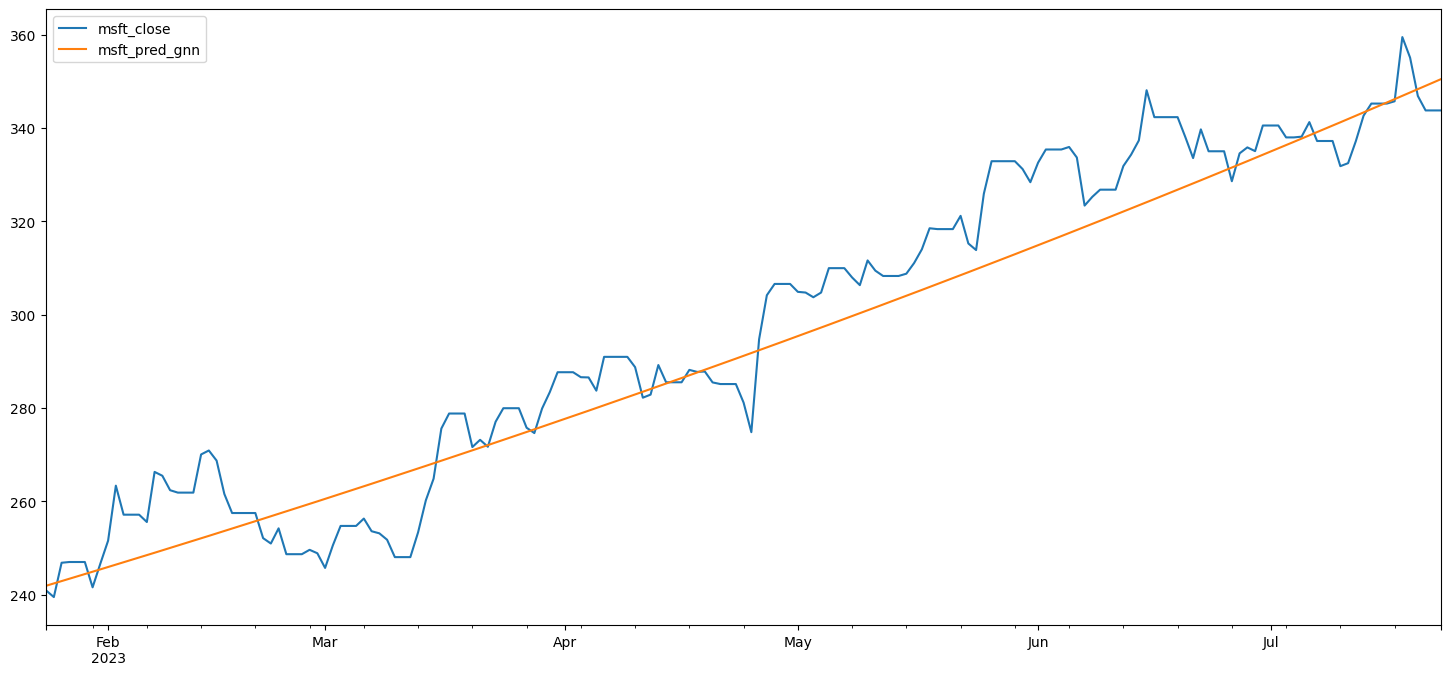

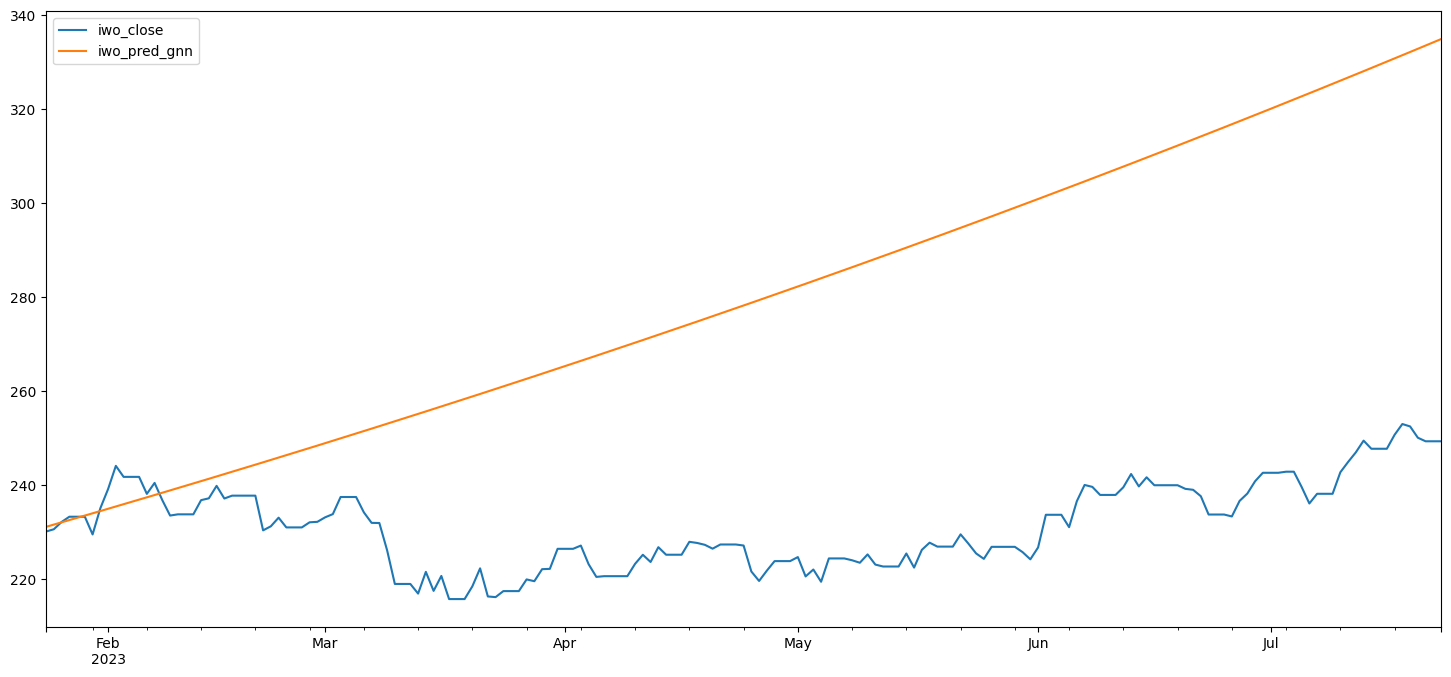

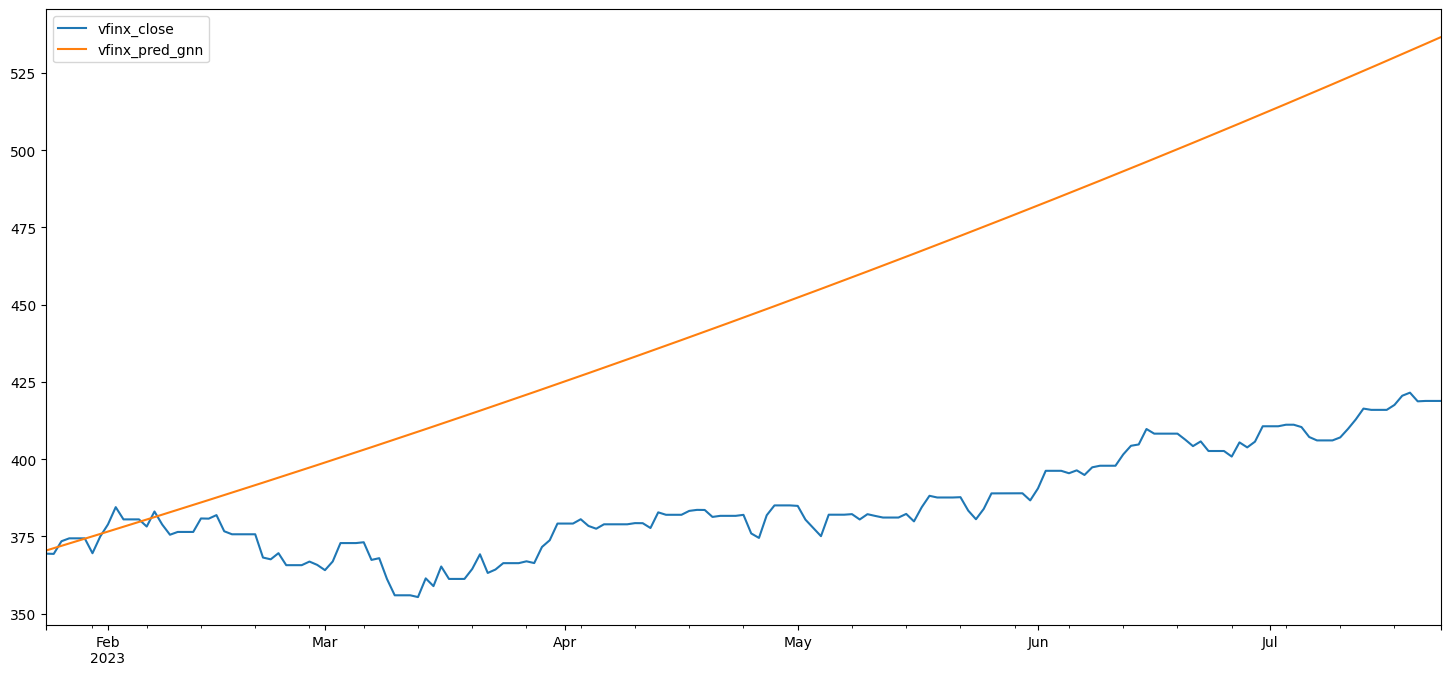

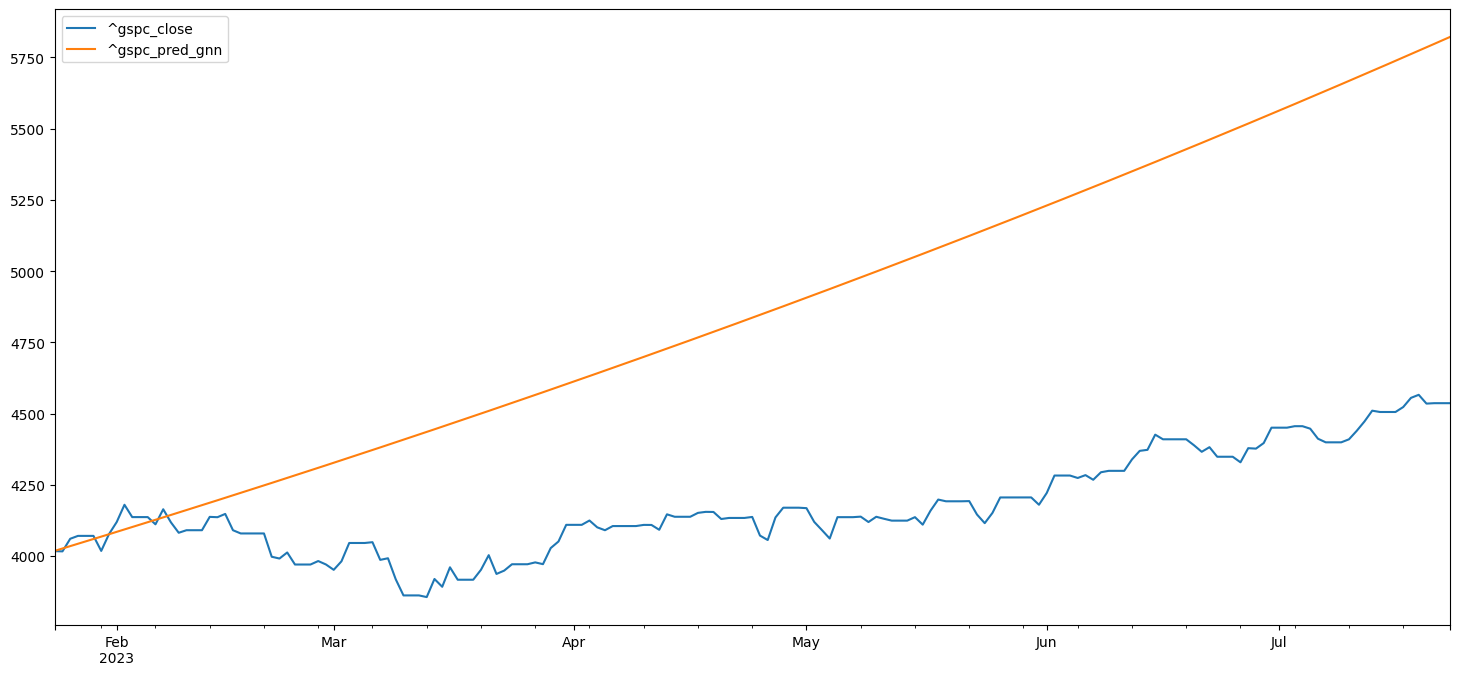

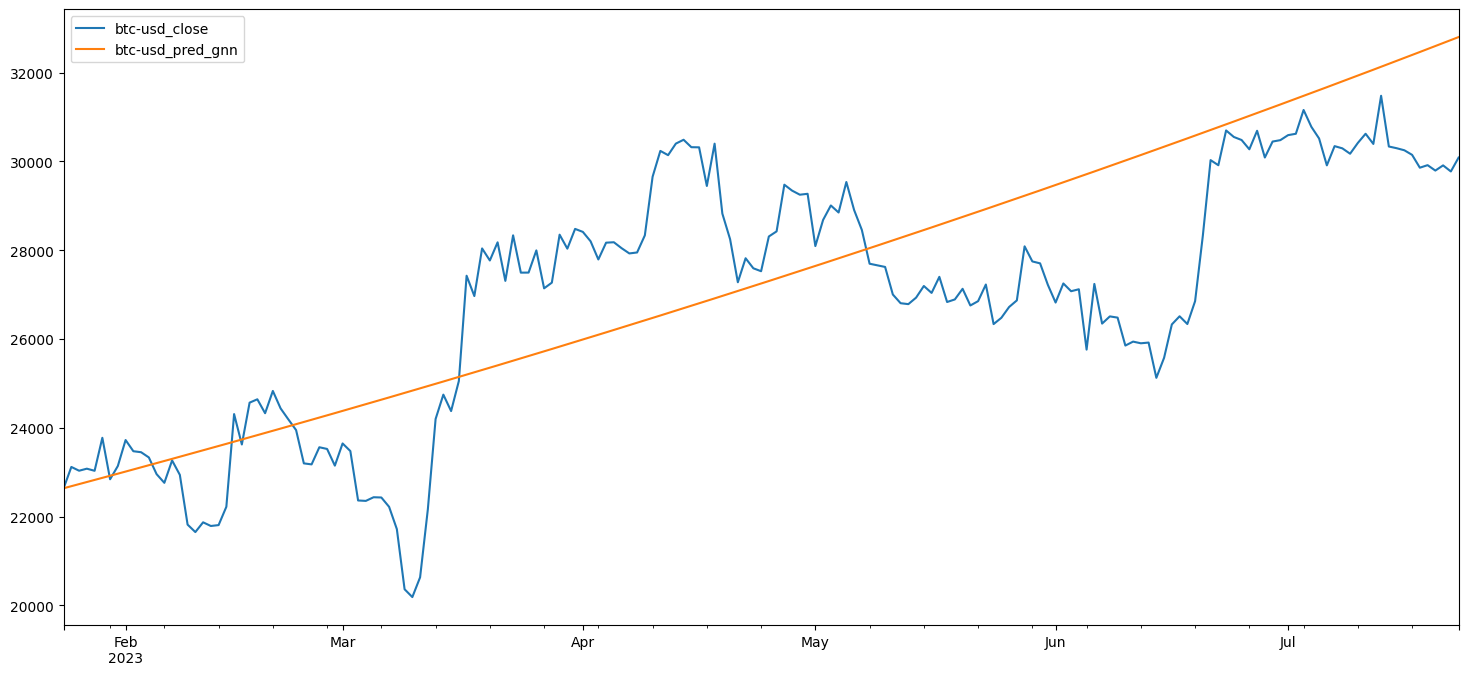

In [210]:
for p_col, pred_col in zip(PRICE_COLS, PRED_COLS_GNN):
    print(p_col)
    print("RMSE GNN: ", (((plot[p_col] - plot[pred_col]) ** 2).mean() ** .5))
    print("RMSE NAIVE: ", (((plot[p_col] - plot[p_col].shift(1)) ** 2).mean() ** .5))
    plot[[p_col, pred_col]].plot(figsize=(18, 8))